In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad

z=np.array([0.07,0.09,0.12,0.17,0.179,0.199,0.20,0.27,0.28,0.352,0.3802,0.4,0.4004,0.4247,0.4497,0.47,0.4783,0.48,0.593,0.68,0.781,0.875,0.88,0.90,1.037,1.3,1.363,1.43,1.53,1.75,1.965])
Hz=np.array([69,69,68.6,83,75,75,72.9,77,88.8,83,83,95,77,87.1,92.8,89,80.9,97,104,92,105,125,90,117,154,168,160,177,140,202,186.5])
err=np.array([19.6,12,26.2,8,4,5,29.6,14,36.6,14,13.5,17,10.2,11.2,12.9,50,9,62,13,8,12,17,40,23,20,17,33.6,18,14,40,50.4])
c = 2.99792458e5
z_bao =  np.array([0.38,0.38,0.51,0.51,0.61,0.61,0.122,0.81,1.52,2.34,2.34])
Aobs_bao = np.array([1512.39,81.2087,1975.22,90.9029,2306.68,98.9647,539,10.75,3843,8.86,37.41])
C_mat = np.array([[624.707, 23.729, 325.332, 8.34963, 157.386, 3.57778,0,0,0,0,0],
                  [23.729, 5.60873, 11.6429, 2.33996, 6.39263, 0.968056,0,0,0,0,0],
                  [325.332, 11.6429, 905.777, 29.3392, 515.271, 14.1013,0,0,0,0,0],
                  [8.34963, 2.33996, 29.3392, 5.42327, 16.1422, 2.85334,0,0,0,0,0],
                  [157.386, 6.39263, 515.271, 16.1422, 1375.12, 40.4327,0,0,0,0,0],
                  [3.57778, 0.968056, 14.1013, 2.85334, 40.4327, 6.25936,0,0,0,0,0],
                  [0,0,0,0,0,0,289,0,0,0,0],
                  [0,0,0,0,0,0,0,0.1849,0,0,0],
                  [0,0,0,0,0,0,0,0,21609,0,0],
                  [0,0,0,0,0,0,0,0,0,0.0841,-0.183396],
                  [0,0,0,0,0,0,0,0,0,-0.183396,3.4596],
                 ])



  0%|          | 0/20000 [00:00<?, ?it/s]C:\Users\swaya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 20000/20000 [00:35<00:00, 556.65it/s]


Parameter estimates:
H0: 69.23 +6.55/-5.69
Omega_M: 0.31 +0.07/-0.07
wx: -1.18 +0.53/-0.51


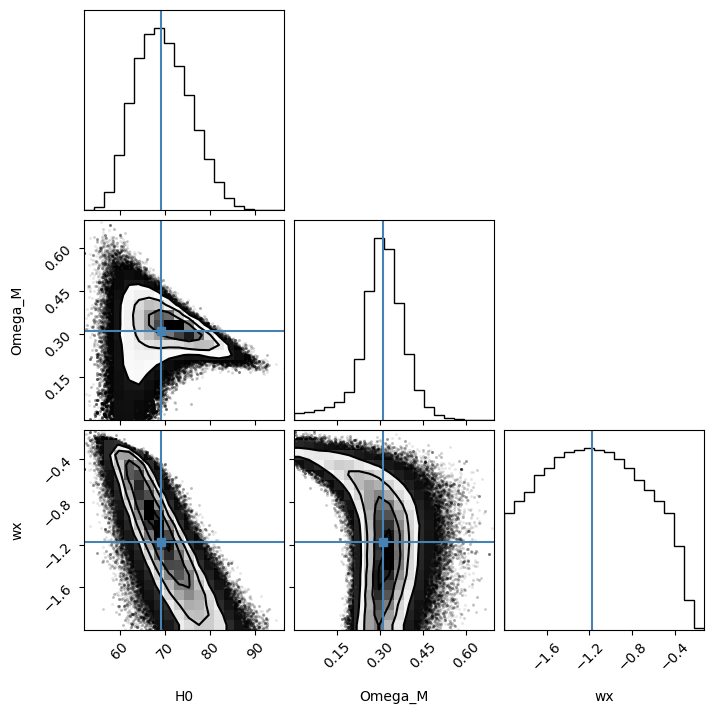

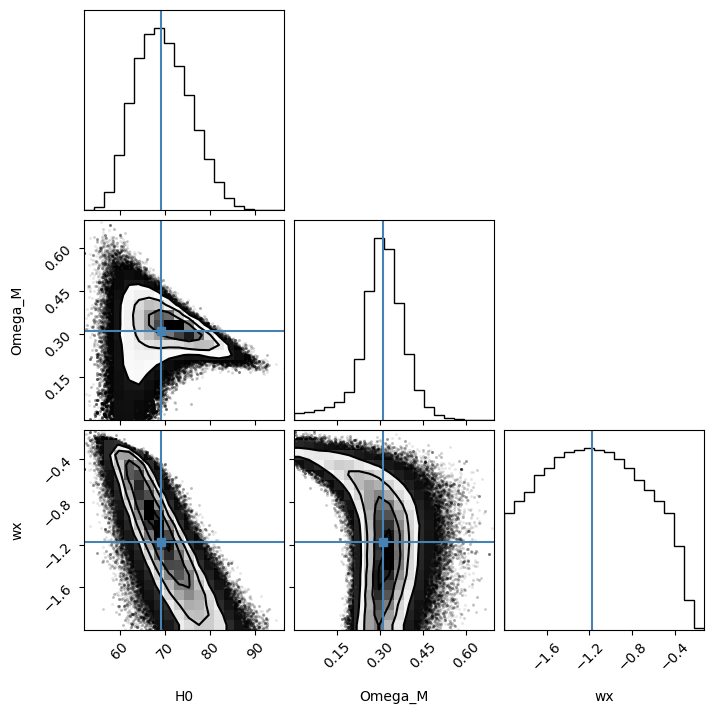

In [2]:
import numpy as np
import emcee
import corner

# Example data (replace with your actual data)
z_data = z
H_data = Hz
uncertainties = err

# Define the LCDM model and chi-squared function
def xcdm_model(params, z):
    H0, Omega_M , wx= params
    return H0 * np.sqrt(Omega_M * (1 + z)**3 + (1 - Omega_M) * (1+z)**(3 * (1+wx)) )

def chi_squared(params, z_data, H_data, uncertainties):
    model_predictions = xcdm_model(params, z_data)
    chi_sq = np.sum(((H_data - model_predictions) / uncertainties) ** 2)
    return chi_sq

# Define log likelihood function for emcee
def log_likelihood(params, z_data, H_data, uncertainties):
    chi_sq = chi_squared(params, z_data, H_data, uncertainties)
    return -0.5 * chi_sq

# Define log prior function for emcee
def log_prior(params):
    H0, Omega_M, wx = params
    # Apply priors here if necessary
    if 50.0 < H0 < 100.0 and 0.0 < Omega_M < 1.0 and -2 < wx < 0:
        return 0.0
    return -np.inf

# Define log probability function for emcee
def log_probability(params, z_data, H_data, uncertainties):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, z_data, H_data, uncertainties)

# Initial guess for parameters
initial_params = [70.0, 0, 0]

# Set up the emcee sampler
n_walkers = 32
n_dim = len(initial_params)
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_probability, args=(z_data, H_data, uncertainties))

# Run the MCMC sampler
n_steps = 20000
sampler.run_mcmc(initial_params + 1e-4 * np.random.randn(n_walkers, n_dim), n_steps, progress=True)

# Get the samples from the MCMC chain
samples = sampler.get_chain(discard=100, flat=True)

# Calculate percentiles for uncertainties
percentiles = np.percentile(samples, [16, 50, 84], axis=0)

# Print and plot the results using corner plot
print("Parameter estimates:")
print("H0: {:.2f} +{:.2f}/-{:.2f}".format(percentiles[1, 0], percentiles[2, 0] - percentiles[1, 0], percentiles[1, 0] - percentiles[0, 0]))
print("Omega_M: {:.2f} +{:.2f}/-{:.2f}".format(percentiles[1, 1], percentiles[2, 1] - percentiles[1, 1], percentiles[1, 1] - percentiles[0, 1]))
print("wx: {:.2f} +{:.2f}/-{:.2f}".format(percentiles[1, 2], percentiles[2, 2] - percentiles[1, 2], percentiles[1, 2] - percentiles[0, 2]))

# Plot corner plot
labels = ['H0', 'Omega_M', 'wx']
corner.corner(samples, labels=labels, truths=percentiles[1, :])

In [3]:
def Xcdm_model(Ho, Omega_M, wx,z):
    return Ho * np.sqrt(Omega_M * (1 + z)**3 + (1 - Omega_M) * (1+z)**(3 * (1+wx)) )
def E(Ho, Omega_M,wx,z):
    term_e = Omega_M * (1 + z)**3 + (1 - Omega_M) * (1+z)**(3 * (1+wx))
    return np.sqrt(term_e)
def DH(Ho,Omega_M,wx,z):
    return c/(Ho*E(Ho,Omega_M,wx,z))
def f(z,Ho,Omega_M,wx,):
    return c/(Ho*E(Ho, Omega_M,wx,z))
def DC(Ho,Omega_M,wx,z):
    val,er=quad(f,0,(z), args=(Ho,Omega_M,wx,))
    return val
def DM(Ho,Omega_M,wx,z):
    return DC(Ho,Omega_M,wx,z)
def DV(Ho,Omega_M,wx,z):
    return ((c/Ho)*(DM(Ho,Omega_M,wx,z)**2)*(z/E(Ho,Omega_M,wx,z)))**(1/3)
def DA(Ho,Omega_M,wx,z):
    return DM(Ho,Omega_M,wx,z)/(1+z)
def rs(Ho,Omega_M):
    h = (Ho/100)
    num = np.exp(-72.3 * ((0.0014 * h**2 + 0.0006)**2))
    den = ((0.02225) ** 0.12807) * (((Omega_M - 0.0014) * h**2) ** 0.25351)
    return 55.154*num/den

rs_fid = 147.78
Wb0_hsq = np.array([0.02225,0.02305,0.02229,0.02305])

def fu(Ho,Omega_M,wx,z_bao):
    Ath_bao = np.zeros(11)
    D_m_range = [0,2,4]
    hub_range = [1,3,5]
    D_v_range = [6,8]
    for i in D_m_range:
        k =  z_bao[i]
        Ath_bao[i] = DM(Ho,Omega_M,wx,k)*rs_fid/rs(Ho,Omega_M)
    for i in hub_range:
        k =  z_bao[i]    
        Ath_bao[i] = Ho*E(Ho,Omega_M,wx,k)*rs(Ho,Omega_M)/rs_fid
    for i in D_v_range:
        k =  z_bao[i]
        Ath_bao[i] = DV(Ho,Omega_M,wx,k)*rs_fid/rs(Ho,Omega_M)
    Ath_bao[7] = DA(Ho,Omega_M,wx,z_bao[7])/(rs(Ho,Omega_M))
    Ath_bao[9] = DH(Ho,Omega_M,wx,z_bao[9])/rs(Ho,Omega_M)
    Ath_bao[10] = DM(Ho,Omega_M,wx,z_bao[10])/rs(Ho,Omega_M)
    return Ath_bao

In [4]:
def chi_new(para,z_bao,Aobs_bao,C_mat):
    Ho, Omega_M,wx=para
    Ath_bao = fu(Ho,Omega_M,wx,z_bao)
    p = Ath_bao - Aobs_bao
    C_inv = np.linalg.inv(C_mat)
    t1 = np.matmul(C_inv,p)
    return np.matmul(p.T, t1)
def chi_sq_XCDM_flat(para,z,Hz,err,z_bao,Aobs_bao,C_mat):
    Ho, Omega_M,wx=para
    chi_squared=0
    for i in range(len(z)):
           chi_squared += ((Hz[i] - Xcdm_model(Ho,Omega_M,wx,z[i])) / err[i]) ** 2
    return chi_squared + chi_new(para,z_bao,Aobs_bao,C_mat)

In [5]:
np.random.seed(99)
nll = lambda *args : chi_sq_XCDM_flat(*args)
H0_ini = 70
Wm0_ini = 0.024
wx_ini = -0.01
initial = np.array([H0_ini,Wm0_ini,wx_ini])

soln = minimize(nll, initial, args=(z,Hz,err,z_bao,Aobs_bao,C_mat),bounds=[(0,np.inf),(0,1),(-2,0)])
H0_opt_XCDM_flat, Wm0_opt_XCDM_flat, Wx = soln.x
print(soln)
H0_opt_XCDM_flat, Wm0_opt_XCDM_flat, Wx

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 19.46634127020951
        x: [ 6.588e+01  3.192e-01 -8.682e-01]
      nit: 21
      jac: [-3.837e-05  8.917e-04 -7.255e-04]
     nfev: 88
     njev: 22
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


(65.88009651851692, 0.31917469970843526, -0.868153571973235)

In [6]:
def log_prior_XCDM_flat(opt):
    Ho, Omega_M, wx = opt
    if 0.1 <= Omega_M <= 0.7 and 50 <= Ho <= 85 and -2<wx<0:
        return 0.0
    return -np.inf
def log_probability_XCDM_flat(opt, z,Hz,err,z_bao,Aobs_bao,C_mat):
    lp = log_prior_XCDM_flat(opt)
    if not np.isfinite(lp):
        return -np.inf
    return lp - 0.5*chi_sq_XCDM_flat(opt,z,Hz,err,z_bao,Aobs_bao,C_mat)
pos = soln.x + 1e-4 * np.random.randn(200, 3)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_XCDM_flat, args = (z,Hz,err,z_bao,Aobs_bao,C_mat))
sampler.run_mcmc(pos, 2000, progress = True)

100%|██████████| 2000/2000 [06:25<00:00,  5.19it/s]


State([[65.46496918  0.35108393 -0.79961596]
 [65.55804331  0.33116574 -0.87427513]
 [60.80039039  0.31271217 -0.62968071]
 [65.66676906  0.28556362 -0.85199423]
 [66.94987135  0.30149289 -0.86562616]
 [69.28739307  0.30524078 -1.05463294]
 [65.0605678   0.33165334 -0.8377438 ]
 [68.87061563  0.29645864 -1.01200246]
 [65.89462119  0.29615291 -0.90207326]
 [65.2228484   0.32026339 -0.85001186]
 [64.36528256  0.32932716 -0.70704887]
 [67.44527932  0.31560795 -0.85291499]
 [65.38292676  0.32977979 -0.81503208]
 [62.99172368  0.34241423 -0.74802269]
 [62.2021038   0.29665401 -0.7274196 ]
 [67.59692634  0.31863595 -0.96775348]
 [65.49453605  0.32147285 -0.85966496]
 [61.01288691  0.31868901 -0.66044665]
 [62.55560876  0.30852055 -0.68164562]
 [65.36282375  0.31018226 -0.88343369]
 [62.68430174  0.32714996 -0.68477623]
 [63.70071374  0.31432953 -0.76328715]
 [66.26869943  0.33232606 -0.89527623]
 [67.05645957  0.3243556  -0.91674387]
 [70.69470496  0.30475677 -1.09290406]
 [66.05789999  0.31

In [7]:
tau_XCDM_flat = sampler.get_autocorr_time()
print(tau_XCDM_flat)

[33.19158697 33.61549321 32.8866329 ]


(400000, 3)


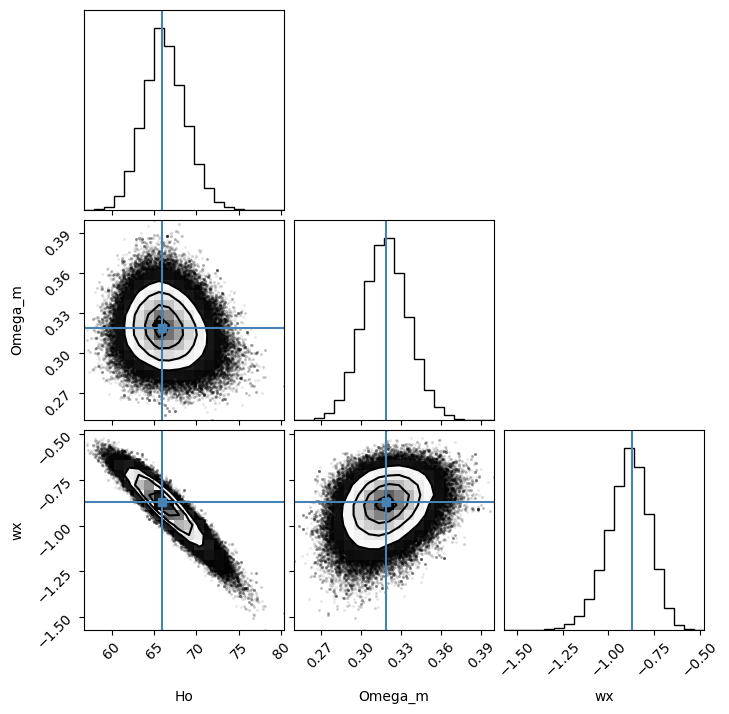

In [8]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)
labels = ["Ho", "Omega_m", "wx"]

fig = corner.corner(
    flat_samples, labels=labels, truths=[H0_opt_XCDM_flat, Wm0_opt_XCDM_flat, Wx]
);

In [9]:
sampler.reset()
sampler.run_mcmc(pos,20000,progress= True)

100%|██████████| 20000/20000 [1:44:42<00:00,  3.18it/s]   


State([[68.58301875  0.323538   -0.95832453]
 [62.20276187  0.34279666 -0.73816053]
 [65.74352283  0.36028083 -0.76342437]
 [63.95453518  0.32246029 -0.7663243 ]
 [66.85481578  0.30349316 -0.94123653]
 [67.16162501  0.32857386 -0.9466626 ]
 [66.48507741  0.32453046 -0.94603414]
 [66.37663742  0.3404546  -0.89831471]
 [69.23351068  0.33397255 -1.01206203]
 [63.72162906  0.33434998 -0.76511767]
 [65.4651739   0.33681098 -0.82535   ]
 [65.03135147  0.2895948  -0.88360962]
 [65.60089002  0.32124637 -0.90699973]
 [68.3282214   0.28413236 -0.99386994]
 [67.79088578  0.32127944 -0.91381435]
 [68.69490294  0.33250278 -0.98877099]
 [62.63289724  0.32490197 -0.76634266]
 [68.23291537  0.32747853 -0.96911066]
 [62.89477159  0.31708214 -0.78529269]
 [66.00984821  0.32432188 -0.8739189 ]
 [64.99768501  0.34056197 -0.78658843]
 [67.26920068  0.31738909 -0.89530422]
 [66.23830953  0.30198063 -0.90668516]
 [72.47340919  0.31759724 -1.15991354]
 [65.79275615  0.31902845 -0.93073423]
 [66.59966156  0.35

In [10]:
tau_XCDM_flat = sampler.get_autocorr_time()
print(tau_XCDM_flat)

[38.18571032 38.74584812 38.56845492]


(4000000, 3)


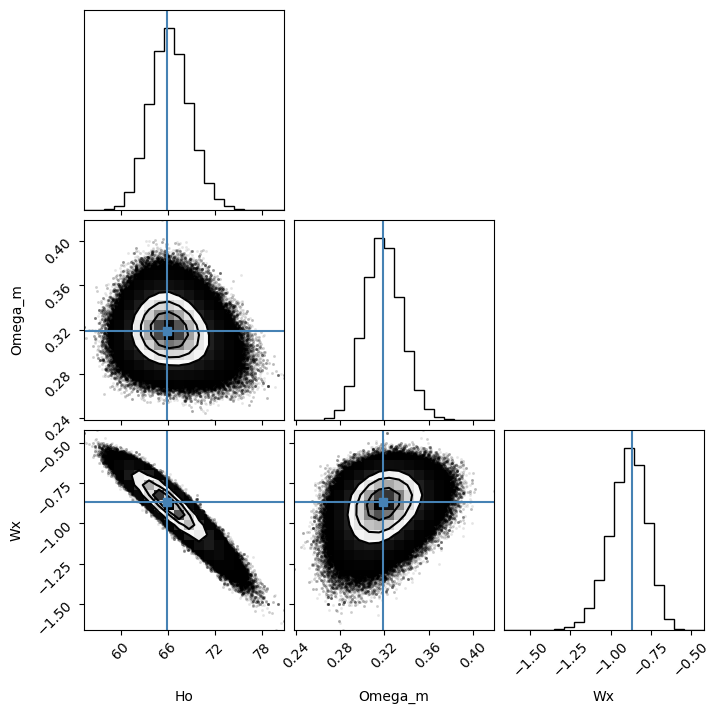

In [11]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)
labels = ["Ho", "Omega_m","Wx"]

fig = corner.corner(
    flat_samples, labels=labels, truths=[H0_opt_XCDM_flat, Wm0_opt_XCDM_flat,Wx]
);

In [12]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84]) 
    q= np.diff(mcmc) 
    txt = "\mathrm{{{3}}} = {0:3}_{{-{1:.3f}}}^{{{2:.3f}}}" 
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [13]:
import getdist
from getdist import plots,MCSamples
import matplotlib.pyplot as plt
names = ["Ho","Omega_M","Wx"]
labels = ["H_0","\Omega_{M}","w{x}"]
samples2 = MCSamples(samples=flat_samples,names = names, labels = labels)
means=samples2.getMeans()
stats=samples2.getMargeStats() 
conf_levels = samples2.contours
print(means)
mcmc

Removed no burn in


[66.31060829  0.31900558 -0.89078943]


array([-1.00390912, -0.88372478, -0.77734064])

In [14]:
lims1 = stats.parWithName('Ho').limits
lims2 = stats.parWithName('Omega_M').limits 
lims3 = stats.parWithName('Wx').limits 
for conf, lim1, lim2, lim3 in zip(samples2.contours,lims1, lims2, lims3):
      if conf != 0.6827:
          continue

      print('value: %.3f, lower: %.3f, upper: %.3f'.format(means[0], lim1.lower - means[0], lim1.upper- means[0]))
      print('value: %.2f, lower: %.2f, upper: %.2f'.format(means[1], lim2.lower - means[1], lim2.upper - means[1]))
      print('value: %.2f, lower: %.2f, upper: %.2f'.format(means[1], lim3.lower - means[1], lim3.upper - means[1]))

<Figure size 600x450 with 0 Axes>

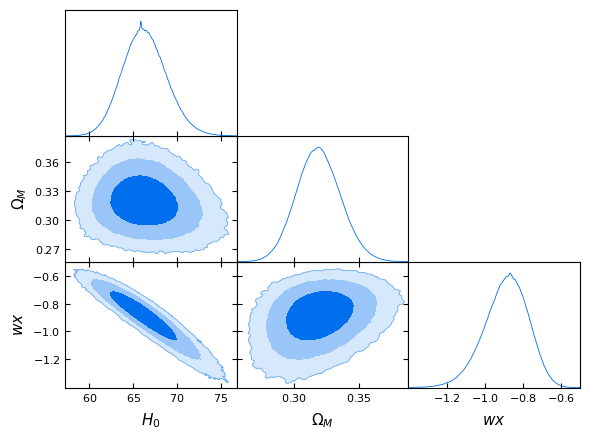

In [15]:
g = plots.get_single_plotter()
samples2.updateSettings({'contours': [0.6827, 0.9545, 0.9973]})
g.settings.num_plot_contours = 4
g.triangle_plot([samples2], filled=True);